## Data Description

The dataset can be found on Kaggle [here](https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k)

Description:
Context
Environmental sensor telemetry data, detailed in the blog post, [Getting Started with IoT Analytics on AWS](https://towardsdatascience.com/getting-started-with-iot-analytics-on-aws-5f2093bcf704), published on Towards Data Science.

*Content:*
The data was generated from a series of three identical, custom-built, breadboard-based sensor arrays. Each array was connected to a Raspberry Pi devices. Each of the three IoT devices was placed in a physical location with varied environmental conditions.

| device            | environmental conditions                 |
|-------------------|------------------------------------------|
| 00:0f:00:70:91:0a | stable conditions, cooler and more humid |
| 1c:bf:ce:15:ec:4d | highly variable temperature and humidity |
| b8:27:eb:bf:9d:51 | stable conditions, warmer and dryer      |

Each IoT device collected a total of seven different readings from the four sensors on a regular interval. Sensor readings include temperature, humidity, carbon monoxide (CO), liquid petroleum gas (LPG), smoke, light, and motion. The data spans the period from 07/12/2020 00:00:00 UTC – 07/19/2020 23:59:59 UTC. There is a total of 405,184 rows of data.

The sensor readings, along with a unique device ID and timestamp, were published as a single message, using the ISO standard Message Queuing Telemetry Transport (MQTT) network protocol. Below is an example of an MQTT message payload.

```
{
  "data": {
    "co": 0.006104480269226063,
    "humidity": 55.099998474121094,
    "light": true,
    "lpg": 0.008895956948783413,
    "motion": false,
    "smoke": 0.023978358312270912,
    "temp": 31.799999237060547
  },
  "device_id": "6e:81:c9:d4:9e:58",
  "ts": 1594419195.292461
}
```


Columns
There are nine columns in the dataset.

| column   | description          | units      |
|----------|----------------------|------------|
| ts       | timestamp of event   | epoch      |
| device   | unique device name   | string     |
| co       | carbon monoxide      | ppm (%)    |
| humidity | humidity             | percentage |
| light    | light detected?      | boolean    |
| lpg      | liquid petroleum gas | ppm (%)    |
| motion   | motion detected?     | boolean    |
| smoke    | smoke                | ppm (%)    |
| temp     | temperature          | Fahrenheit |

### Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Ingesting Data

In [44]:
df = pd.read_csv('../data/iot_telemetry_data.csv')
df

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000
...,...,...,...,...,...,...,...,...,...
405179,1.595203e+09,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405180,1.595203e+09,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000
405181,1.595203e+09,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000
405182,1.595203e+09,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
dtypes: bool(2), float64(6), object(1)
memory usage: 22.4+ MB


In [46]:
df['ts'] = pd.to_datetime(df['ts'], unit='s')

In [47]:
df

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-12 00:01:34.385974528,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,2020-07-12 00:01:34.735567616,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,2020-07-12 00:01:38.073572864,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,2020-07-12 00:01:39.589145856,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,2020-07-12 00:01:41.761234944,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000
...,...,...,...,...,...,...,...,...,...
405179,2020-07-20 00:03:33.162014976,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405180,2020-07-20 00:03:33.576560640,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000
405181,2020-07-20 00:03:36.167959296,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000
405182,2020-07-20 00:03:36.979521536,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001


In [48]:
df['device'].unique()

array(['b8:27:eb:bf:9d:51', '00:0f:00:70:91:0a', '1c:bf:ce:15:ec:4d'],
      dtype=object)

In [49]:
df['condition'] = df['device'].map({'b8:27:eb:bf:9d:51':'stable conditions, warmer and dryer', 
                                    '00:0f:00:70:91:0a':'stable conditions, cooler and more humid',
                                    '1c:bf:ce:15:ec:4d':'highly variable temperature and humidity'})

In [50]:
df

,ts,device,co,humidity,light,lpg,motion,smoke,temp,condition
0,2020-07-12 00:01:34.385974528,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,"stable conditions, warmer and dryer"
1,2020-07-12 00:01:34.735567616,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,"stable conditions, cooler and more humid"
2,2020-07-12 00:01:38.073572864,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,"stable conditions, warmer and dryer"
3,2020-07-12 00:01:39.589145856,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,highly variable temperature and humidity
4,2020-07-12 00:01:41.761234944,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,"stable conditions, warmer and dryer"
...,...,...,...,...,...,...,...,...,...,...
405179,2020-07-20 00:03:33.162014976,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001,"stable conditions, cooler and more humid"
405180,2020-07-20 00:03:33.576560640,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000,"stable conditions, warmer and dryer"
405181,2020-07-20 00:03:36.167959296,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000,highly variable temperature and humidity
405182,2020-07-20 00:03:36.979521536,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001,"stable conditions, cooler and more humid"


In [51]:
df[df.select_dtypes(include=['int', 'float', 'bool']).columns].corr()

,co,humidity,light,lpg,motion,smoke,temp
co,1.000000,-0.656750,-0.230197,0.997331,-0.000706,0.998192,0.110905
humidity,-0.656750,1.000000,0.079703,-0.672113,-0.009826,-0.669863,-0.410427
light,-0.230197,0.079703,1.000000,-0.208926,0.033594,-0.212969,0.747485
lpg,0.997331,-0.672113,-0.208926,1.000000,0.000232,0.999916,0.136396
motion,-0.000706,-0.009826,0.033594,0.000232,1.000000,0.000062,0.037649
smoke,0.998192,-0.669863,-0.212969,0.999916,0.000062,1.000000,0.131891
temp,0.110905,-0.410427,0.747485,0.136396,0.037649,0.131891,1.000000


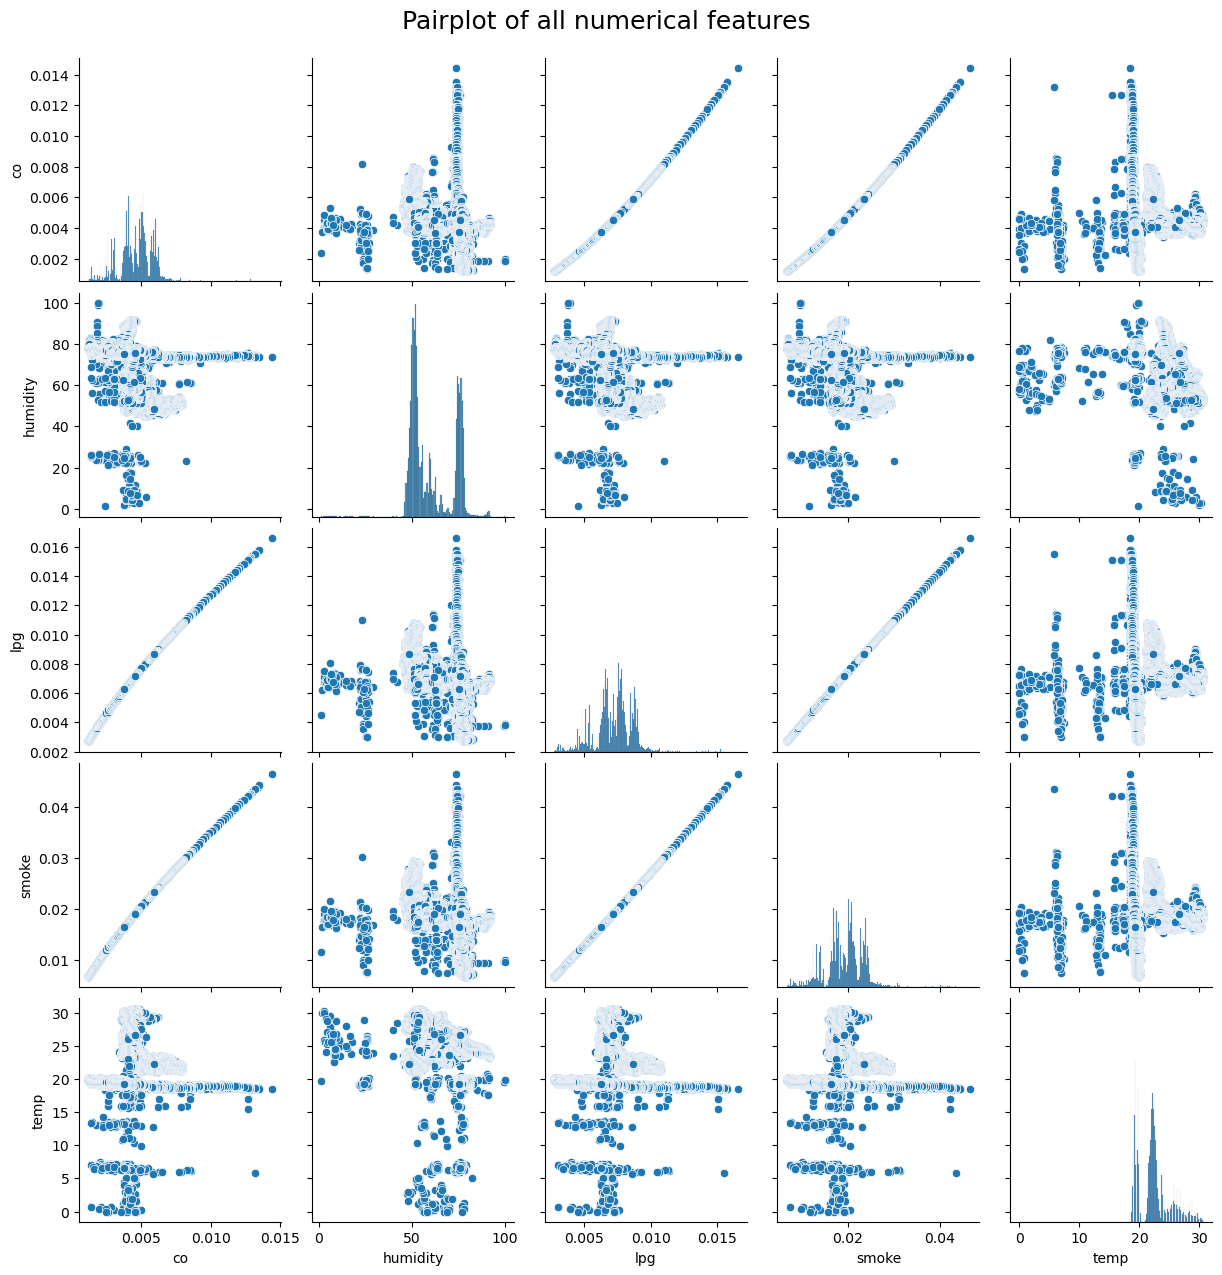

In [69]:
import seaborn as sns
sns.pairplot(df[df.select_dtypes(include=['int', 'float']).columns])
plt.suptitle('Pairplot of all numerical features', y=1.02, fontsize=18)
plt.show()

In [53]:
df[['co', 'humidity', 'light', 'lpg', 'motion', 'smoke', 'temp']].corr()

,co,humidity,light,lpg,motion,smoke,temp
co,1.000000,-0.656750,-0.230197,0.997331,-0.000706,0.998192,0.110905
humidity,-0.656750,1.000000,0.079703,-0.672113,-0.009826,-0.669863,-0.410427
light,-0.230197,0.079703,1.000000,-0.208926,0.033594,-0.212969,0.747485
lpg,0.997331,-0.672113,-0.208926,1.000000,0.000232,0.999916,0.136396
motion,-0.000706,-0.009826,0.033594,0.000232,1.000000,0.000062,0.037649
smoke,0.998192,-0.669863,-0.212969,0.999916,0.000062,1.000000,0.131891
temp,0.110905,-0.410427,0.747485,0.136396,0.037649,0.131891,1.000000


<AxesSubplot:xlabel='humidity', ylabel='temp'>

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


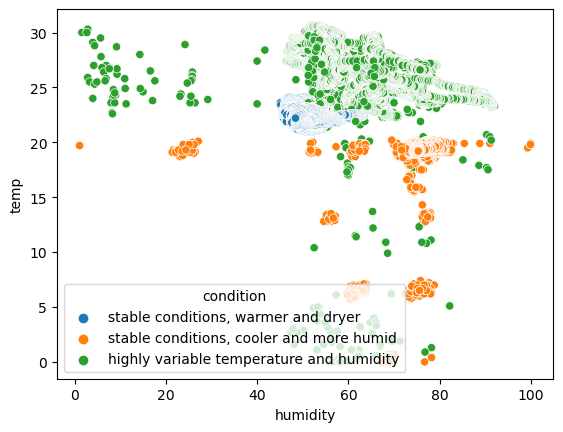

In [63]:
import seaborn as sns

sns.scatterplot(data=df, x='humidity', y='temp', hue='condition')

In [56]:
df['ts'].max() - df['ts'].min()

Timedelta('8 days 00:02:02.878338048')

In [ ]:
df['ts'].sample

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ts         405184 non-null  datetime64[ns]
 1   device     405184 non-null  object        
 2   co         405184 non-null  float64       
 3   humidity   405184 non-null  float64       
 4   light      405184 non-null  bool          
 5   lpg        405184 non-null  float64       
 6   motion     405184 non-null  bool          
 7   smoke      405184 non-null  float64       
 8   temp       405184 non-null  float64       
 9   condition  405184 non-null  object        
dtypes: bool(2), datetime64[ns](1), float64(5), object(2)
memory usage: 25.5+ MB


In [83]:
df.set_index('ts').resample('D').mean(numeric_only=True)

,co,humidity,light,lpg,motion,smoke,temp
ts,,,,,,,
2020-07-12,0.004494,61.898795,0.301554,0.007074,0.001863,0.018799,22.274593
2020-07-13,0.004866,59.882391,0.274077,0.007531,0.001496,0.020079,21.981636
2020-07-14,0.004587,59.792232,0.290167,0.007223,0.001203,0.019201,22.309407
2020-07-15,0.004418,57.955801,0.274100,0.007000,0.001273,0.018582,22.866575
2020-07-16,0.004800,59.422866,0.302723,0.007404,0.000960,0.019745,22.438689
2020-07-17,0.004407,64.199625,0.253721,0.006886,0.000695,0.018313,22.188920
2020-07-18,0.004937,60.275372,0.256940,0.007588,0.001218,0.020254,22.647671
2020-07-19,0.004606,60.702666,0.268146,0.007196,0.000820,0.019149,22.911253
2020-07-20,0.004947,63.205469,0.250000,0.007613,0.000000,0.020317,22.627344


<AxesSubplot:xlabel='ts'>

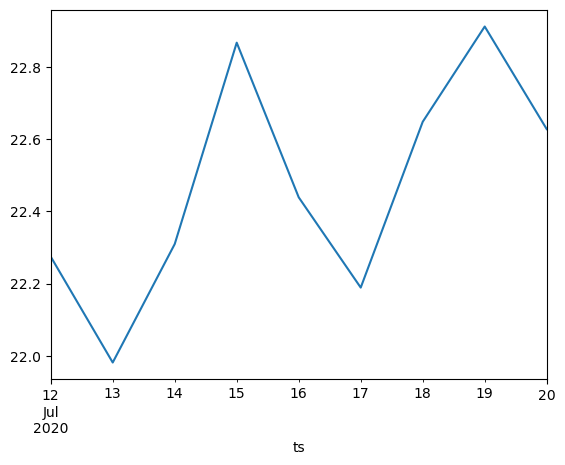

In [90]:
df.set_index('ts').resample('D').mean(numeric_only=True)['temp'].plot()

In [ ]:
sns.boxenplot(data=df, x='ts', y='temp', hue='condition')